In [15]:
%matplotlib inline
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from preparation.data import Data
import h5py
import os
import shutil

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
def leakyReLU(x, alpha):
    return tf.maximum(alpha*x, x)

In [3]:
# Simple function to plot number images.
def plot_images(plt_num, images, dim):
    # Standard parameters for the plot.
    
    mpl.rcParams["figure.figsize"] = dim, dim
    fig = plt.figure()
    for i in range(0, plt_num):
        fig.add_subplot(1, 10, i+1)
        img = images[i, :, :, :]
        plt.imshow(img)
    plt.show()

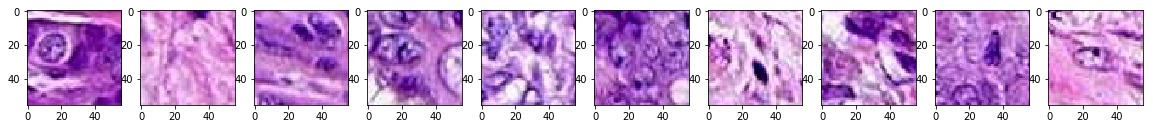

In [4]:
data = Data(patch_h=56, patch_w=56, n_channels=3, batch_size=10)
images, label = data.training.next_batch(10)

plot_images(plt_num=10, images=images, dim=20)

In [5]:
def model_inputs(image_width, image_height, image_channels, z_dim):
    real_images = tf.placeholder(dtype=tf.float32, shape=(None, image_width, image_height, image_channels), name='real_images')
    z_input = tf.placeholder(dtype=tf.float32, shape=(None, z_dim), name='z_input')
    learning_rate = tf.placeholder(dtype=tf.float32, name='learning_rate')
    return real_images, z_input, learning_rate

In [6]:
def discriminator(images, reuse, alpha):
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Padding = 'Same' -> H_new = H_old // Stride
        
        # First layer: Conv2d -> LeakyReLU
        # Input Shape: (28, 28, 1)
        # Output Shape: (16, 16, 64)
        c1 = tf.layers.conv2d(inputs=images, filters=64, kernel_size=(5,5), strides=(2, 2), padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer(), name='c1')
        leaky_c1 = leakyReLU(c1, alpha)
        
        # Second layer: Conv2d -> BN -> LeakyReLU
        # Input Shape: (16, 16, 64)
        # Output Shape: (8, 8, 128)
        c2 = tf.layers.conv2d(inputs=leaky_c1, filters=128, kernel_size=(5,5), strides=(2, 2), padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer(), name='c2')
        bc2 = tf.layers.batch_normalization(c2, training=True)
        leaky_c2 = leakyReLU(bc2, alpha)
        
        c3 = tf.layers.conv2d(inputs=leaky_c2, filters=256, kernel_size=(5,5), strides=(2, 2), padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer(), name='c3')
        bc3 = tf.layers.batch_normalization(c3, training=True)
        leaky_c3 = leakyReLU(bc3, alpha)

        flatten = tf.layers.flatten(leaky_c3, name='flatten')

        # Dense.
        fully1 = tf.layers.dense(flatten, 1024, activation=None)
        bn_fully1 = tf.layers.batch_normalization(fully1, training=True)
        leaky_fully1 = leakyReLU(bn_fully1, alpha)
        
        # Dense
        logits = tf.layers.dense(leaky_fully1, 1, activation=None)
        output = tf.nn.sigmoid(logits)
        
        return output, logits

In [7]:
def generator(z_input, out_channel_dim, reuse, is_train, alpha):
    
    with tf.variable_scope('generator', reuse=reuse):
        
        # Fully
        fully1 = tf.layers.dense(inputs=z_input, units=1024, activation=None)
        bn_fully1 = tf.layers.batch_normalization(fully1, training=is_train)
        leaky_bfc1 = leakyReLU(bn_fully1, alpha)
        # Doesn't work ReLU
        # leaky_bfc1 = tf.nn.relu(bn_fully1)
        
        # Fully
        fully2 = tf.layers.dense(inputs=leaky_bfc1, units=256*7*7, activation=None)
        bn_fully2 = tf.layers.batch_normalization(fully2, training=is_train)
        leaky_bfc2 = leakyReLU(bn_fully2, alpha)
        # Doesn't work ReLU
        # leaky_bfc2 = tf.nn.relu(bn_fully2)
        
        fc_reshape = tf.reshape(leaky_bfc2, (-1, 7, 7, 256))
        
        # Conv
        c1 = tf.layers.conv2d_transpose(inputs=fc_reshape, filters=256, kernel_size=(5,5), strides=(2,2), padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer(), name='c1')
        bc1 = tf.layers.batch_normalization(c1, training=is_train)
        leaky_c1 = leakyReLU(bc1, alpha)
        # Doesn't work ReLU
        # leaky_c1 = tf.nn.relu(bc1)
        
        # Conv
        c2 = tf.layers.conv2d_transpose(inputs=leaky_c1, filters=128, kernel_size=(5,5), strides=(1,1), padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer(), name='c2')
        bc2 = tf.layers.batch_normalization(c2, training=is_train)
        leaky_c2 = leakyReLU(bc2, alpha)
        # Doesn't work ReLU
        # leaky_c2 = tf.nn.relu(bc2)
        
        c3 = tf.layers.conv2d_transpose(inputs=leaky_c2, filters=128, kernel_size=(5,5), strides=(2,2), padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer(), name='c3')
        bc3 = tf.layers.batch_normalization(c3, training=is_train)
        leaky_c3 = leakyReLU(bc3, alpha)
        # Doesn't work ReLU
        # leaky_c3 = tf.nn.relu(bc3)
        
        # Conv
        logits = tf.layers.conv2d_transpose(inputs=leaky_c3, filters=out_channel_dim, kernel_size=(5,5), strides=(2,2), 
                                            padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer(), 
                                            name='logits')
        output = tf.nn.sigmoid(logits, name='output')
        
        return output

In [8]:
def show_generated(session, output_fake, n_images, z_input):
    z_dim = z_input.get_shape()[-1]
    sample_z = np.random.uniform(low=-1., high=1., size=(n_images, z_dim))
    feed_dict = {z_input:sample_z}
    gen_samples = session.run(output_fake, feed_dict=feed_dict)
    plot_images(plt_num=n_images, images=gen_samples, dim=20)    
    return gen_samples, sample_z

In [9]:
def save_loss(losses, data_out_path, dim):    
    mpl.rcParams["figure.figsize"] = dim, dim
    plt.rcParams.update({'font.size': 22})
    losses = np.array(losses)
    fig, ax = plt.subplots()
    plt.plot(losses[:, 0], label='Discriminator', alpha=0.5)
    plt.plot(losses[:, 1], label='Generator', alpha=0.5)
    plt.title("Training Losses")
    plt.legend()
    plt.savefig('%s/training_loss.png' % data_out_path)

In [ ]:
def setup_output(epochs, data, n_images, image_height, image_width, image_channels, z_dim, data_out_path):
    checkpoints_path = os.path.join(data_out_path, 'checkpoints')
    checkpoints = os.path.join(checkpoints_path, 'DCGAN.ckt')
    gen_images_path = os.path.join(data_out_path, 'images')
    gen_images = os.path.join(gen_images_path, 'gen_images.h5')
    latent_images = os.path.join(gen_images_path, 'latent_images.h5')
    if os.path.isdir(checkpoints_path):
         shutil.rmtree(checkpoints_path)
    if os.path.isdir(gen_images_path):
         shutil.rmtree(gen_images_path)
    os.makedirs(checkpoints_path)
    os.makedirs(gen_images_path)

    size_img = (epochs*data.training.iterations)//show_epochs
    img_db_shape = (size_img, n_images, image_height, image_width, image_channels)
    latent_db_shape = (size_img, n_images, z_dim)
    hdf5_gen = h5py.File(gen_images, mode='w')
    hdf5_latent = h5py.File(latent_images, mode='w')
    img_storage = hdf5_gen.create_dataset(name='generated_img', shape=img_db_shape, dtype=np.float32)
    latent_storage = hdf5_latent.create_dataset(name='generated_img', shape=latent_db_shape, dtype=np.float32)
    return img_storage, latent_storage

In [10]:
def loss(real_images, z_input, out_channel_dim, alpha):
    
    # Generator.
    fake_images = generator(z_input, out_channel_dim=out_channel_dim, reuse=False, is_train=True, alpha=alpha)
    
    # Discriminator.
    output_fake, logits_fake = discriminator(images=fake_images, reuse=False, alpha=alpha) 
    output_real, logits_real = discriminator(images=real_images, reuse=True, alpha=alpha)
    
    # Discriminator loss.
    loss_dis_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=tf.zeros_like(output_fake)))
    loss_dis_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_real, labels=tf.ones_like(output_fake)*0.9))
    loss_dis = loss_dis_fake + loss_dis_real

    # Generator loss.
    # This is where we implement -log[D(G(z))] instead log[1-D(G(z))].
    # Recall the implementation of cross-entropy, sign already in. 
    loss_gen = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=tf.ones_like(output_fake)))
    
    return loss_dis, loss_gen, loss_dis_fake, loss_dis_real

In [11]:
def optimization(loss_dis, loss_gen, learning_rate, beta1):
    trainable_variables = tf.trainable_variables()
    generator_variables = [variable for variable in trainable_variables if variable.name.startswith('generator')]
    discriminator_variables = [variable for variable in trainable_variables if variable.name.startswith('discriminator')]
    
    # Handling Batch Normalization.
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        train_generator = tf.train.AdamOptimizer(learning_rate=learning_rate, 
                                                 beta1=beta1).minimize(loss_gen, var_list=generator_variables)
        train_discriminator = tf.train.AdamOptimizer(learning_rate=learning_rate, 
                                                     beta1=beta1).minimize(loss_dis, var_list=discriminator_variables)    
    return train_generator, train_discriminator

In [23]:
def train(epochs, batch_size, z_dim, learning_rate, beta1, data, alpha, image_width, image_height, image_channels, data_out_path):
    
    real_images, z_input, learning_rate_input = model_inputs(image_width=image_width, image_height=image_height, image_channels=image_channels, z_dim=z_dim)
    loss_dis, loss_gen, loss_dis_fake, loss_dis_real = loss(real_images=real_images, z_input=z_input, out_channel_dim=image_channels, alpha=alpha)
    train_generator, train_discriminator = optimization(loss_dis=loss_dis, loss_gen=loss_gen, learning_rate=learning_rate_input, beta1=beta1)
    
    output_gen = generator(z_input=z_input, out_channel_dim=image_channels, reuse=True, is_train=False, alpha=alpha)

    global losses 
    global samples 
    
    run_epochs = 0    
    show_epochs = 100
    print_epochs = 10
    n_images = 10
        
    losses = list()
    samples = list()

    #Saver for model weights/bias, and generated images.
    saver = tf.train.Saver()
    
    img_storage, latent_storage = setup_output(epochs, data, n_images, image_height, image_width, image_channels, z_dim, data_out_path)
    
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())
        for epoch in range(epochs+1):
            for batch_images, batch_labels in data.training:
                z_batch = np.random.uniform(low=-1., high=1., size=(batch_size, z_dim))
               
                feed_dict = {z_input:z_batch, real_images:batch_images, learning_rate_input: learning_rate}
                session.run(train_discriminator, feed_dict=feed_dict)
                session.run(train_generator, feed_dict=feed_dict)
               
                if run_epochs%print_epochs==0:
                    feed_dict = {z_input:z_batch, real_images:batch_images}
                    epoch_loss_dis = session.run(loss_dis, feed_dict=feed_dict)
                    epoch_loss_gen = session.run(loss_gen, feed_dict=feed_dict)
                    losses.append((epoch_loss_dis, epoch_loss_gen))
                    print('Epochs %s/%s: Generator Loss: %s. Discriminator Loss: %s' % (epoch, epochs, np.round(epoch_loss_gen, 3), np.round(epoch_loss_dis, 3)))
                if run_epochs%show_epochs == 0:
                    gen_samples, sample_z = show_generated(session=session, output_fake=output_gen, n_images=n_images, z_input=z_input)
                    img_storage[run_epochs//show_epochs] = gen_samples
                    latent_storage[run_epochs//show_epochs] = sample_z
                    saver.save(sess = session, save_path=checkpoints, global_step=run_epochs)
                
                run_epochs+=1
                
        

Epochs 0/2: Generator Loss: 3.465. Discriminator Loss: 5.323


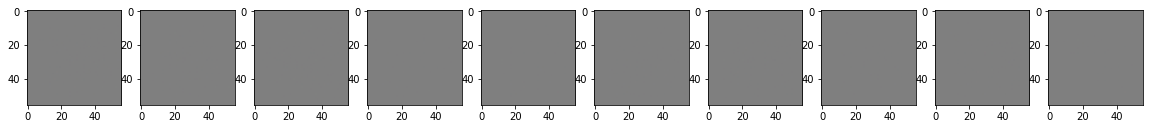

Epochs 0/2: Generator Loss: 4.564. Discriminator Loss: 5.627
Epochs 0/2: Generator Loss: 3.385. Discriminator Loss: 4.409
Epochs 0/2: Generator Loss: 2.831. Discriminator Loss: 3.883
Epochs 0/2: Generator Loss: 2.196. Discriminator Loss: 2.914
Epochs 0/2: Generator Loss: 2.88. Discriminator Loss: 3.419
Epochs 0/2: Generator Loss: 1.909. Discriminator Loss: 2.477
Epochs 0/2: Generator Loss: 0.923. Discriminator Loss: 1.596
Epochs 0/2: Generator Loss: 0.719. Discriminator Loss: 1.432
Epochs 0/2: Generator Loss: 0.761. Discriminator Loss: 1.376
Epochs 0/2: Generator Loss: 0.829. Discriminator Loss: 1.289


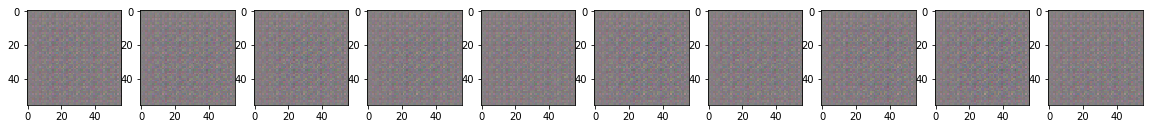

Epochs 0/2: Generator Loss: 0.78. Discriminator Loss: 1.345
Epochs 0/2: Generator Loss: 0.796. Discriminator Loss: 1.351
Epochs 0/2: Generator Loss: 0.789. Discriminator Loss: 1.322
Epochs 0/2: Generator Loss: 0.765. Discriminator Loss: 1.363
Epochs 0/2: Generator Loss: 0.759. Discriminator Loss: 1.279
Epochs 0/2: Generator Loss: 0.762. Discriminator Loss: 1.382
Epochs 0/2: Generator Loss: 0.771. Discriminator Loss: 1.378
Epochs 0/2: Generator Loss: 0.781. Discriminator Loss: 1.374
Epochs 0/2: Generator Loss: 0.828. Discriminator Loss: 1.352
Epochs 0/2: Generator Loss: 0.779. Discriminator Loss: 1.329


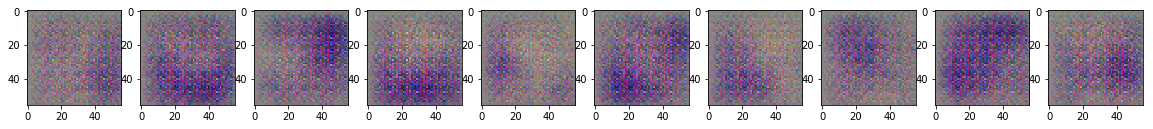

Epochs 0/2: Generator Loss: 0.837. Discriminator Loss: 1.298
Epochs 0/2: Generator Loss: 0.874. Discriminator Loss: 1.321
Epochs 0/2: Generator Loss: 0.785. Discriminator Loss: 1.357
Epochs 0/2: Generator Loss: 0.81. Discriminator Loss: 1.311
Epochs 0/2: Generator Loss: 0.822. Discriminator Loss: 1.347
Epochs 0/2: Generator Loss: 0.831. Discriminator Loss: 1.303
Epochs 0/2: Generator Loss: 0.823. Discriminator Loss: 1.305
Epochs 0/2: Generator Loss: 0.761. Discriminator Loss: 1.396
Epochs 0/2: Generator Loss: 0.829. Discriminator Loss: 1.314
Epochs 0/2: Generator Loss: 0.832. Discriminator Loss: 1.304


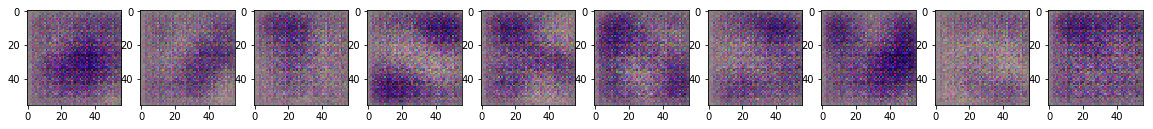

Epochs 0/2: Generator Loss: 0.808. Discriminator Loss: 1.315
Epochs 0/2: Generator Loss: 0.79. Discriminator Loss: 1.352
Epochs 0/2: Generator Loss: 0.829. Discriminator Loss: 1.296
Epochs 0/2: Generator Loss: 0.856. Discriminator Loss: 1.283
Epochs 0/2: Generator Loss: 0.822. Discriminator Loss: 1.307
Epochs 0/2: Generator Loss: 0.819. Discriminator Loss: 1.328
Epochs 0/2: Generator Loss: 0.765. Discriminator Loss: 1.422
Epochs 0/2: Generator Loss: 0.861. Discriminator Loss: 1.244
Epochs 0/2: Generator Loss: 0.825. Discriminator Loss: 1.281
Epochs 0/2: Generator Loss: 0.84. Discriminator Loss: 1.357


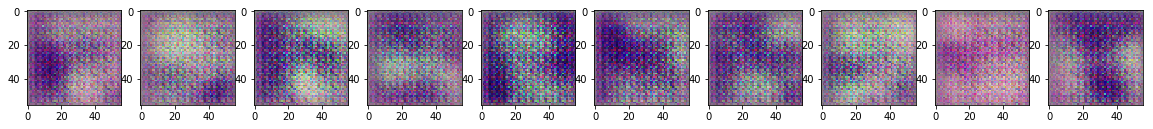

Epochs 0/2: Generator Loss: 0.813. Discriminator Loss: 1.301
Epochs 0/2: Generator Loss: 0.853. Discriminator Loss: 1.255
Epochs 0/2: Generator Loss: 0.797. Discriminator Loss: 1.256
Epochs 0/2: Generator Loss: 0.829. Discriminator Loss: 1.271
Epochs 0/2: Generator Loss: 0.97. Discriminator Loss: 1.535
Epochs 0/2: Generator Loss: 0.753. Discriminator Loss: 1.488
Epochs 0/2: Generator Loss: 0.822. Discriminator Loss: 1.315
Epochs 0/2: Generator Loss: 0.869. Discriminator Loss: 1.304
Epochs 0/2: Generator Loss: 0.724. Discriminator Loss: 1.365
Epochs 0/2: Generator Loss: 0.743. Discriminator Loss: 1.39


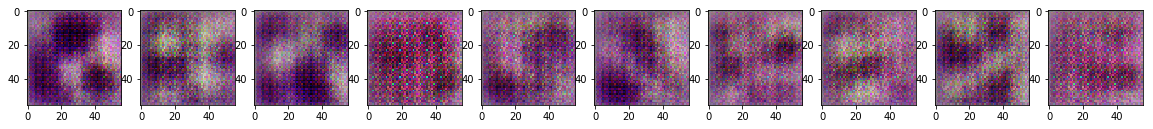

Epochs 0/2: Generator Loss: 0.892. Discriminator Loss: 1.238
Epochs 0/2: Generator Loss: 0.889. Discriminator Loss: 1.305
Epochs 0/2: Generator Loss: 0.901. Discriminator Loss: 1.297
Epochs 0/2: Generator Loss: 0.831. Discriminator Loss: 1.386
Epochs 0/2: Generator Loss: 0.79. Discriminator Loss: 1.419
Epochs 0/2: Generator Loss: 0.782. Discriminator Loss: 1.355
Epochs 0/2: Generator Loss: 0.735. Discriminator Loss: 1.401
Epochs 0/2: Generator Loss: 0.844. Discriminator Loss: 1.308
Epochs 0/2: Generator Loss: 0.896. Discriminator Loss: 1.369
Epochs 0/2: Generator Loss: 0.711. Discriminator Loss: 1.408


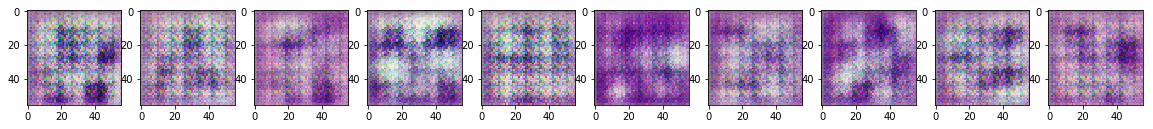

Epochs 0/2: Generator Loss: 0.815. Discriminator Loss: 1.284
Epochs 0/2: Generator Loss: 0.783. Discriminator Loss: 1.332
Epochs 0/2: Generator Loss: 0.787. Discriminator Loss: 1.325
Epochs 0/2: Generator Loss: 0.754. Discriminator Loss: 1.362
Epochs 0/2: Generator Loss: 0.913. Discriminator Loss: 1.174
Epochs 0/2: Generator Loss: 0.815. Discriminator Loss: 1.349
Epochs 0/2: Generator Loss: 0.717. Discriminator Loss: 1.325
Epochs 0/2: Generator Loss: 0.867. Discriminator Loss: 1.247
Epochs 0/2: Generator Loss: 0.809. Discriminator Loss: 1.334
Epochs 0/2: Generator Loss: 0.819. Discriminator Loss: 1.386


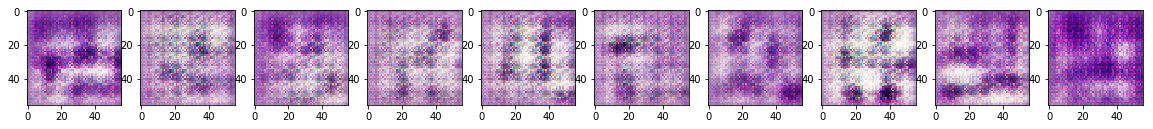

Epochs 0/2: Generator Loss: 0.826. Discriminator Loss: 1.315
Epochs 0/2: Generator Loss: 0.843. Discriminator Loss: 1.349
Epochs 0/2: Generator Loss: 0.639. Discriminator Loss: 1.369
Epochs 0/2: Generator Loss: 0.919. Discriminator Loss: 1.175
Epochs 0/2: Generator Loss: 0.861. Discriminator Loss: 1.206
Epochs 0/2: Generator Loss: 0.888. Discriminator Loss: 1.258
Epochs 0/2: Generator Loss: 0.832. Discriminator Loss: 1.302
Epochs 0/2: Generator Loss: 0.806. Discriminator Loss: 1.339
Epochs 0/2: Generator Loss: 0.947. Discriminator Loss: 1.301
Epochs 0/2: Generator Loss: 0.849. Discriminator Loss: 1.365


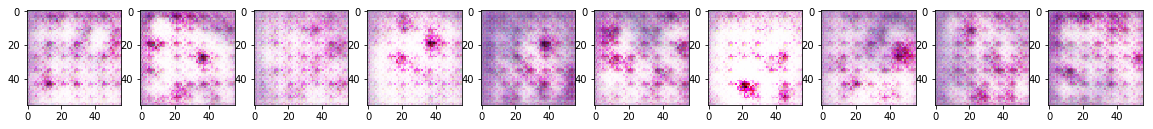

Epochs 0/2: Generator Loss: 0.874. Discriminator Loss: 1.31
Epochs 0/2: Generator Loss: 0.758. Discriminator Loss: 1.327
Epochs 0/2: Generator Loss: 0.63. Discriminator Loss: 1.455
Epochs 0/2: Generator Loss: 0.821. Discriminator Loss: 1.24
Epochs 0/2: Generator Loss: 0.857. Discriminator Loss: 1.315
Epochs 0/2: Generator Loss: 0.903. Discriminator Loss: 1.447
Epochs 0/2: Generator Loss: 0.817. Discriminator Loss: 1.261
Epochs 0/2: Generator Loss: 0.751. Discriminator Loss: 1.203
Epochs 0/2: Generator Loss: 0.827. Discriminator Loss: 1.299
Epochs 0/2: Generator Loss: 0.947. Discriminator Loss: 1.136


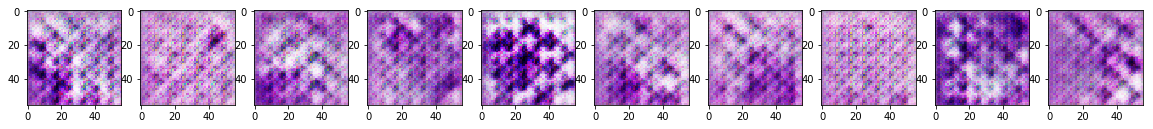

Epochs 0/2: Generator Loss: 0.598. Discriminator Loss: 1.536
Epochs 0/2: Generator Loss: 0.745. Discriminator Loss: 1.34
Epochs 0/2: Generator Loss: 0.89. Discriminator Loss: 1.157
Epochs 0/2: Generator Loss: 0.988. Discriminator Loss: 1.215
Epochs 0/2: Generator Loss: 0.843. Discriminator Loss: 1.188
Epochs 0/2: Generator Loss: 0.775. Discriminator Loss: 1.286
Epochs 0/2: Generator Loss: 0.853. Discriminator Loss: 1.213
Epochs 0/2: Generator Loss: 0.928. Discriminator Loss: 1.219
Epochs 0/2: Generator Loss: 0.756. Discriminator Loss: 1.368
Epochs 0/2: Generator Loss: 0.819. Discriminator Loss: 1.215


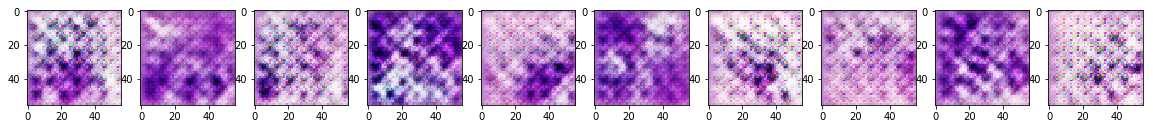

Epochs 0/2: Generator Loss: 0.872. Discriminator Loss: 1.352
Epochs 0/2: Generator Loss: 0.799. Discriminator Loss: 1.27
Epochs 0/2: Generator Loss: 0.744. Discriminator Loss: 1.369
Epochs 0/2: Generator Loss: 0.829. Discriminator Loss: 1.255
Epochs 0/2: Generator Loss: 0.859. Discriminator Loss: 1.134
Epochs 0/2: Generator Loss: 0.779. Discriminator Loss: 1.244
Epochs 0/2: Generator Loss: 0.811. Discriminator Loss: 1.295
Epochs 0/2: Generator Loss: 0.764. Discriminator Loss: 1.394
Epochs 0/2: Generator Loss: 0.714. Discriminator Loss: 1.411
Epochs 0/2: Generator Loss: 0.826. Discriminator Loss: 1.367


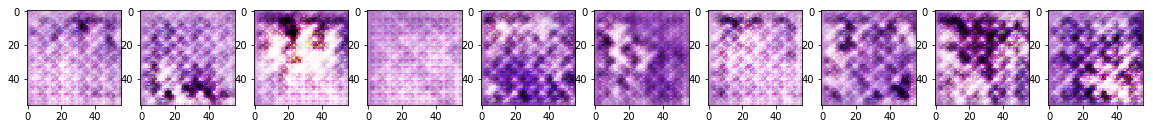

Epochs 0/2: Generator Loss: 0.776. Discriminator Loss: 1.423
Epochs 0/2: Generator Loss: 0.823. Discriminator Loss: 1.279
Epochs 0/2: Generator Loss: 0.806. Discriminator Loss: 1.286
Epochs 0/2: Generator Loss: 0.86. Discriminator Loss: 1.34
Epochs 0/2: Generator Loss: 0.749. Discriminator Loss: 1.322
Epochs 0/2: Generator Loss: 0.7. Discriminator Loss: 1.442
Epochs 0/2: Generator Loss: 0.756. Discriminator Loss: 1.262
Epochs 0/2: Generator Loss: 0.813. Discriminator Loss: 1.264
Epochs 0/2: Generator Loss: 0.803. Discriminator Loss: 1.307
Epochs 0/2: Generator Loss: 0.962. Discriminator Loss: 1.222


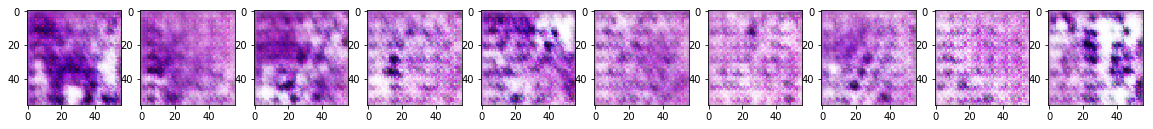

Epochs 0/2: Generator Loss: 0.751. Discriminator Loss: 1.418
Epochs 0/2: Generator Loss: 0.734. Discriminator Loss: 1.338
Epochs 0/2: Generator Loss: 0.811. Discriminator Loss: 1.353
Epochs 0/2: Generator Loss: 0.758. Discriminator Loss: 1.353
Epochs 0/2: Generator Loss: 0.672. Discriminator Loss: 1.588
Epochs 0/2: Generator Loss: 0.862. Discriminator Loss: 1.313
Epochs 0/2: Generator Loss: 0.737. Discriminator Loss: 1.443
Epochs 0/2: Generator Loss: 0.68. Discriminator Loss: 1.49
Epochs 0/2: Generator Loss: 0.835. Discriminator Loss: 1.283
Epochs 0/2: Generator Loss: 0.79. Discriminator Loss: 1.337


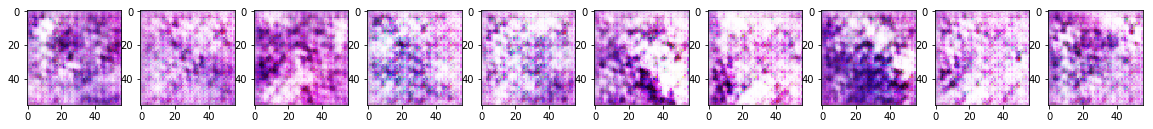

Epochs 0/2: Generator Loss: 0.735. Discriminator Loss: 1.355
Epochs 0/2: Generator Loss: 0.794. Discriminator Loss: 1.273
Epochs 0/2: Generator Loss: 0.784. Discriminator Loss: 1.301
Epochs 0/2: Generator Loss: 0.804. Discriminator Loss: 1.275
Epochs 0/2: Generator Loss: 0.661. Discriminator Loss: 1.44
Epochs 0/2: Generator Loss: 0.673. Discriminator Loss: 1.37
Epochs 0/2: Generator Loss: 0.735. Discriminator Loss: 1.36
Epochs 0/2: Generator Loss: 0.823. Discriminator Loss: 1.321
Epochs 0/2: Generator Loss: 0.758. Discriminator Loss: 1.262
Epochs 0/2: Generator Loss: 0.848. Discriminator Loss: 1.268


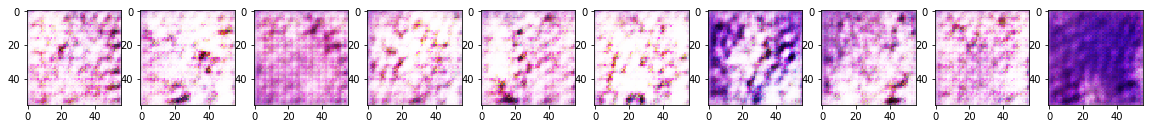

Epochs 0/2: Generator Loss: 0.802. Discriminator Loss: 1.301
Epochs 0/2: Generator Loss: 0.733. Discriminator Loss: 1.37
Epochs 0/2: Generator Loss: 0.8. Discriminator Loss: 1.382
Epochs 0/2: Generator Loss: 0.705. Discriminator Loss: 1.341
Epochs 0/2: Generator Loss: 0.809. Discriminator Loss: 1.328
Epochs 0/2: Generator Loss: 0.774. Discriminator Loss: 1.417
Epochs 0/2: Generator Loss: 0.763. Discriminator Loss: 1.366
Epochs 0/2: Generator Loss: 0.758. Discriminator Loss: 1.374
Epochs 0/2: Generator Loss: 0.741. Discriminator Loss: 1.327
Epochs 0/2: Generator Loss: 0.781. Discriminator Loss: 1.317


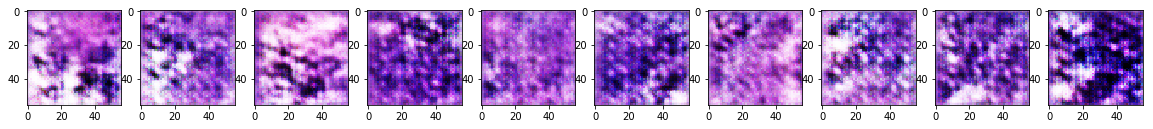

Epochs 0/2: Generator Loss: 0.793. Discriminator Loss: 1.377
Epochs 0/2: Generator Loss: 0.695. Discriminator Loss: 1.442
Epochs 0/2: Generator Loss: 0.839. Discriminator Loss: 1.297
Epochs 0/2: Generator Loss: 0.74. Discriminator Loss: 1.384
Epochs 0/2: Generator Loss: 0.788. Discriminator Loss: 1.312
Epochs 0/2: Generator Loss: 0.768. Discriminator Loss: 1.314
Epochs 0/2: Generator Loss: 0.71. Discriminator Loss: 1.441
Epochs 0/2: Generator Loss: 0.697. Discriminator Loss: 1.397
Epochs 0/2: Generator Loss: 0.767. Discriminator Loss: 1.277
Epochs 0/2: Generator Loss: 0.795. Discriminator Loss: 1.336


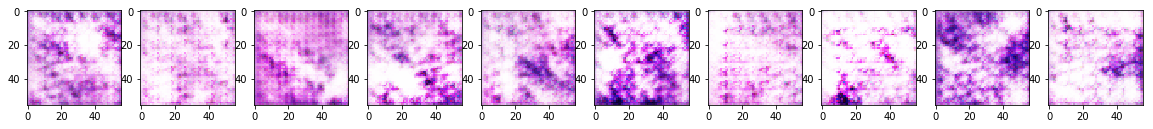

Epochs 0/2: Generator Loss: 0.748. Discriminator Loss: 1.402
Epochs 0/2: Generator Loss: 0.766. Discriminator Loss: 1.355
Epochs 0/2: Generator Loss: 0.717. Discriminator Loss: 1.408
Epochs 0/2: Generator Loss: 0.787. Discriminator Loss: 1.289
Epochs 0/2: Generator Loss: 0.82. Discriminator Loss: 1.346
Epochs 0/2: Generator Loss: 0.694. Discriminator Loss: 1.412
Epochs 0/2: Generator Loss: 0.786. Discriminator Loss: 1.311
Epochs 0/2: Generator Loss: 0.756. Discriminator Loss: 1.356
Epochs 0/2: Generator Loss: 0.744. Discriminator Loss: 1.404
Epochs 0/2: Generator Loss: 0.782. Discriminator Loss: 1.364


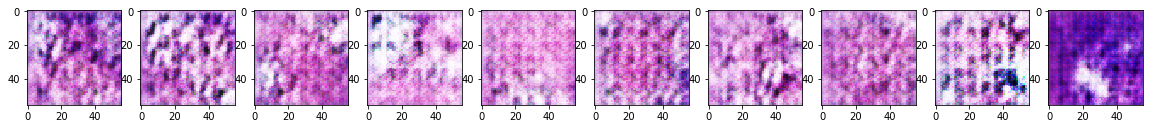

Epochs 0/2: Generator Loss: 0.789. Discriminator Loss: 1.323
Epochs 0/2: Generator Loss: 0.774. Discriminator Loss: 1.322
Epochs 0/2: Generator Loss: 0.771. Discriminator Loss: 1.318
Epochs 0/2: Generator Loss: 0.815. Discriminator Loss: 1.325
Epochs 0/2: Generator Loss: 0.849. Discriminator Loss: 1.318
Epochs 0/2: Generator Loss: 0.759. Discriminator Loss: 1.338
Epochs 0/2: Generator Loss: 0.756. Discriminator Loss: 1.326
Epochs 0/2: Generator Loss: 0.81. Discriminator Loss: 1.301
Epochs 0/2: Generator Loss: 0.742. Discriminator Loss: 1.316
Epochs 0/2: Generator Loss: 0.785. Discriminator Loss: 1.378


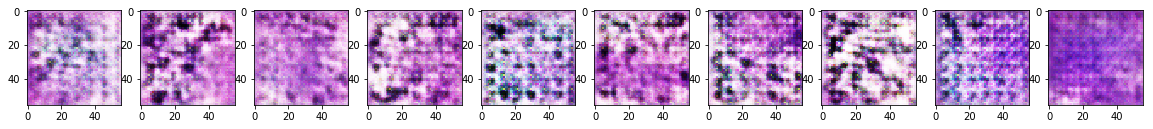

Epochs 0/2: Generator Loss: 0.765. Discriminator Loss: 1.331
Epochs 0/2: Generator Loss: 0.778. Discriminator Loss: 1.38
Epochs 0/2: Generator Loss: 0.776. Discriminator Loss: 1.34
Epochs 0/2: Generator Loss: 0.751. Discriminator Loss: 1.355
Epochs 0/2: Generator Loss: 0.778. Discriminator Loss: 1.39
Epochs 0/2: Generator Loss: 0.767. Discriminator Loss: 1.322
Epochs 0/2: Generator Loss: 0.8. Discriminator Loss: 1.314
Epochs 0/2: Generator Loss: 0.689. Discriminator Loss: 1.366
Epochs 0/2: Generator Loss: 0.801. Discriminator Loss: 1.308
Epochs 0/2: Generator Loss: 0.827. Discriminator Loss: 1.272


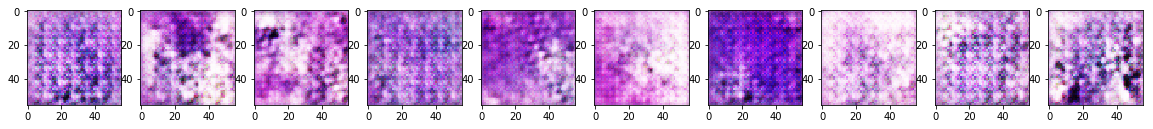

Epochs 0/2: Generator Loss: 0.837. Discriminator Loss: 1.298
Epochs 0/2: Generator Loss: 0.781. Discriminator Loss: 1.373
Epochs 0/2: Generator Loss: 0.726. Discriminator Loss: 1.271
Epochs 0/2: Generator Loss: 0.741. Discriminator Loss: 1.294
Epochs 0/2: Generator Loss: 0.733. Discriminator Loss: 1.344
Epochs 0/2: Generator Loss: 0.694. Discriminator Loss: 1.387
Epochs 0/2: Generator Loss: 0.808. Discriminator Loss: 1.31
Epochs 0/2: Generator Loss: 0.831. Discriminator Loss: 1.357
Epochs 0/2: Generator Loss: 0.702. Discriminator Loss: 1.388
Epochs 0/2: Generator Loss: 0.745. Discriminator Loss: 1.347


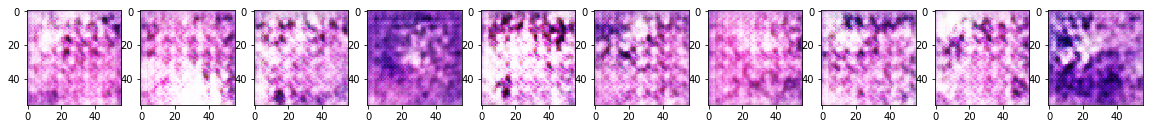

Epochs 0/2: Generator Loss: 0.728. Discriminator Loss: 1.416
Epochs 0/2: Generator Loss: 0.725. Discriminator Loss: 1.414
Epochs 0/2: Generator Loss: 0.748. Discriminator Loss: 1.381
Epochs 0/2: Generator Loss: 0.778. Discriminator Loss: 1.344
Epochs 0/2: Generator Loss: 0.746. Discriminator Loss: 1.317
Epochs 0/2: Generator Loss: 0.818. Discriminator Loss: 1.417
Epochs 0/2: Generator Loss: 0.813. Discriminator Loss: 1.308
Epochs 0/2: Generator Loss: 0.822. Discriminator Loss: 1.283
Epochs 0/2: Generator Loss: 0.758. Discriminator Loss: 1.348
Epochs 0/2: Generator Loss: 0.837. Discriminator Loss: 1.291


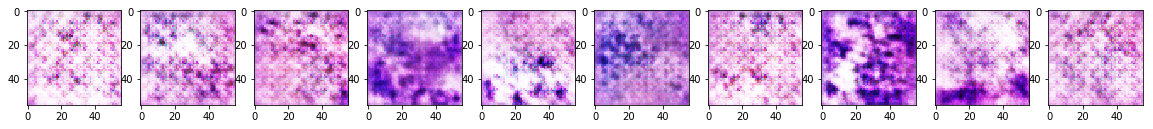

Epochs 0/2: Generator Loss: 0.79. Discriminator Loss: 1.364
Epochs 0/2: Generator Loss: 0.753. Discriminator Loss: 1.403
Epochs 0/2: Generator Loss: 0.77. Discriminator Loss: 1.309
Epochs 0/2: Generator Loss: 0.73. Discriminator Loss: 1.416
Epochs 0/2: Generator Loss: 0.784. Discriminator Loss: 1.321
Epochs 0/2: Generator Loss: 0.766. Discriminator Loss: 1.388
Epochs 0/2: Generator Loss: 0.825. Discriminator Loss: 1.33
Epochs 0/2: Generator Loss: 0.775. Discriminator Loss: 1.348
Epochs 0/2: Generator Loss: 0.795. Discriminator Loss: 1.348
Epochs 0/2: Generator Loss: 0.776. Discriminator Loss: 1.315


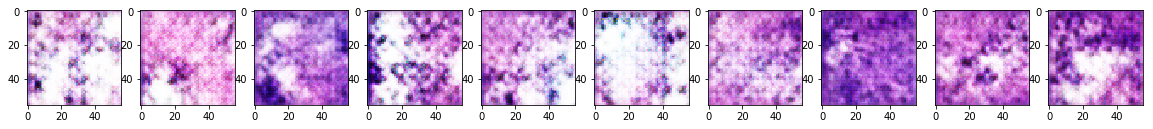

Epochs 0/2: Generator Loss: 0.788. Discriminator Loss: 1.384
Epochs 0/2: Generator Loss: 0.768. Discriminator Loss: 1.374
Epochs 0/2: Generator Loss: 0.807. Discriminator Loss: 1.197
Epochs 0/2: Generator Loss: 0.762. Discriminator Loss: 1.292
Epochs 0/2: Generator Loss: 0.82. Discriminator Loss: 1.357
Epochs 0/2: Generator Loss: 0.8. Discriminator Loss: 1.299
Epochs 0/2: Generator Loss: 0.806. Discriminator Loss: 1.346
Epochs 0/2: Generator Loss: 0.78. Discriminator Loss: 1.328
Epochs 0/2: Generator Loss: 0.794. Discriminator Loss: 1.371
Epochs 0/2: Generator Loss: 0.781. Discriminator Loss: 1.294


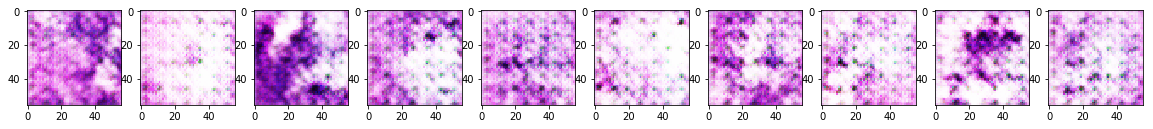

Epochs 0/2: Generator Loss: 0.833. Discriminator Loss: 1.281
Epochs 0/2: Generator Loss: 0.865. Discriminator Loss: 1.297
Epochs 0/2: Generator Loss: 0.793. Discriminator Loss: 1.358
Epochs 0/2: Generator Loss: 0.798. Discriminator Loss: 1.298
Epochs 0/2: Generator Loss: 0.751. Discriminator Loss: 1.43
Epochs 0/2: Generator Loss: 0.788. Discriminator Loss: 1.273
Epochs 0/2: Generator Loss: 0.76. Discriminator Loss: 1.438
Epochs 0/2: Generator Loss: 0.8. Discriminator Loss: 1.346
Epochs 0/2: Generator Loss: 0.763. Discriminator Loss: 1.335
Epochs 0/2: Generator Loss: 0.78. Discriminator Loss: 1.284


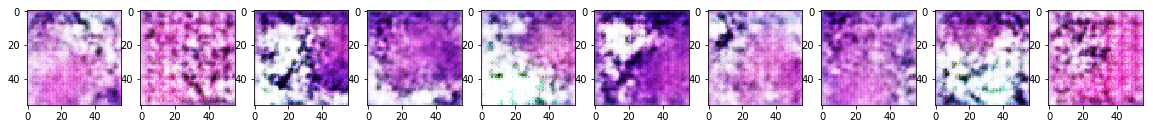

Epochs 0/2: Generator Loss: 0.785. Discriminator Loss: 1.386
Epochs 0/2: Generator Loss: 0.739. Discriminator Loss: 1.342
Epochs 0/2: Generator Loss: 0.788. Discriminator Loss: 1.287
Epochs 0/2: Generator Loss: 0.838. Discriminator Loss: 1.321
Epochs 0/2: Generator Loss: 0.774. Discriminator Loss: 1.429
Epochs 0/2: Generator Loss: 0.797. Discriminator Loss: 1.372
Epochs 0/2: Generator Loss: 0.758. Discriminator Loss: 1.301
Epochs 0/2: Generator Loss: 0.792. Discriminator Loss: 1.271
Epochs 0/2: Generator Loss: 0.802. Discriminator Loss: 1.35
Epochs 0/2: Generator Loss: 0.808. Discriminator Loss: 1.299


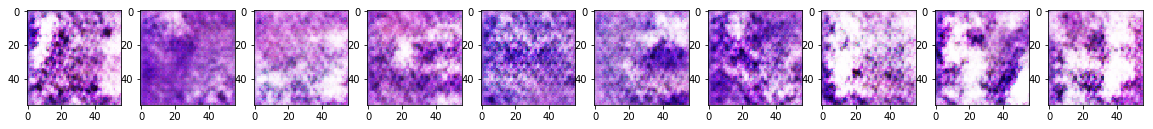

Epochs 0/2: Generator Loss: 0.738. Discriminator Loss: 1.433
Epochs 0/2: Generator Loss: 0.765. Discriminator Loss: 1.246
Epochs 0/2: Generator Loss: 0.795. Discriminator Loss: 1.314
Epochs 0/2: Generator Loss: 0.941. Discriminator Loss: 1.234
Epochs 0/2: Generator Loss: 0.841. Discriminator Loss: 1.184
Epochs 0/2: Generator Loss: 1.164. Discriminator Loss: 0.997
Epochs 0/2: Generator Loss: 1.206. Discriminator Loss: 1.097
Epochs 0/2: Generator Loss: 1.193. Discriminator Loss: 0.913
Epochs 0/2: Generator Loss: 0.852. Discriminator Loss: 1.143
Epochs 0/2: Generator Loss: 0.608. Discriminator Loss: 1.532


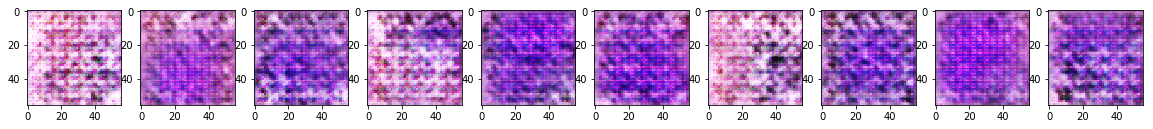

Epochs 0/2: Generator Loss: 0.839. Discriminator Loss: 1.295
Epochs 0/2: Generator Loss: 0.832. Discriminator Loss: 1.277
Epochs 0/2: Generator Loss: 0.886. Discriminator Loss: 1.203
Epochs 0/2: Generator Loss: 0.82. Discriminator Loss: 1.312
Epochs 0/2: Generator Loss: 0.846. Discriminator Loss: 1.337
Epochs 0/2: Generator Loss: 0.817. Discriminator Loss: 1.234
Epochs 0/2: Generator Loss: 0.776. Discriminator Loss: 1.299
Epochs 0/2: Generator Loss: 0.774. Discriminator Loss: 1.256
Epochs 0/2: Generator Loss: 0.85. Discriminator Loss: 1.215
Epochs 0/2: Generator Loss: 0.738. Discriminator Loss: 1.306


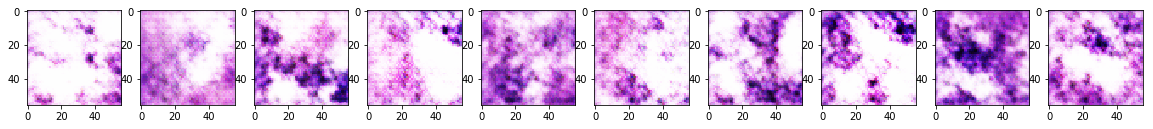

Epochs 0/2: Generator Loss: 0.764. Discriminator Loss: 1.374
Epochs 0/2: Generator Loss: 0.832. Discriminator Loss: 1.288
Epochs 0/2: Generator Loss: 0.778. Discriminator Loss: 1.32
Epochs 0/2: Generator Loss: 0.789. Discriminator Loss: 1.275
Epochs 0/2: Generator Loss: 0.791. Discriminator Loss: 1.334
Epochs 0/2: Generator Loss: 0.849. Discriminator Loss: 1.379
Epochs 0/2: Generator Loss: 0.715. Discriminator Loss: 1.345
Epochs 0/2: Generator Loss: 0.674. Discriminator Loss: 1.408
Epochs 0/2: Generator Loss: 0.807. Discriminator Loss: 1.39
Epochs 0/2: Generator Loss: 0.692. Discriminator Loss: 1.39


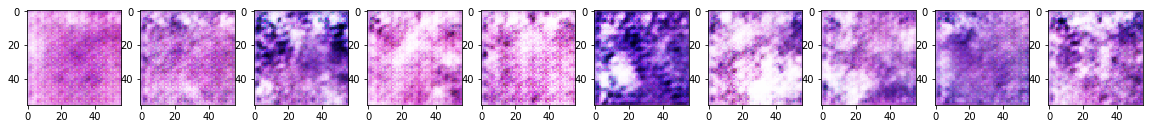

Epochs 0/2: Generator Loss: 0.774. Discriminator Loss: 1.308
Epochs 0/2: Generator Loss: 0.733. Discriminator Loss: 1.358
Epochs 0/2: Generator Loss: 0.748. Discriminator Loss: 1.313
Epochs 0/2: Generator Loss: 0.851. Discriminator Loss: 1.507
Epochs 0/2: Generator Loss: 0.785. Discriminator Loss: 1.339
Epochs 0/2: Generator Loss: 0.799. Discriminator Loss: 1.303
Epochs 0/2: Generator Loss: 0.822. Discriminator Loss: 1.361
Epochs 0/2: Generator Loss: 0.778. Discriminator Loss: 1.329
Epochs 0/2: Generator Loss: 0.797. Discriminator Loss: 1.379
Epochs 0/2: Generator Loss: 0.826. Discriminator Loss: 1.306


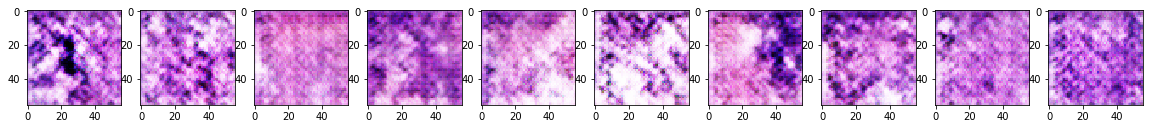

Epochs 0/2: Generator Loss: 0.769. Discriminator Loss: 1.393
Epochs 0/2: Generator Loss: 0.693. Discriminator Loss: 1.3
Epochs 0/2: Generator Loss: 1.045. Discriminator Loss: 1.176
Epochs 0/2: Generator Loss: 1.08. Discriminator Loss: 1.21
Epochs 0/2: Generator Loss: 0.661. Discriminator Loss: 1.281
Epochs 0/2: Generator Loss: 0.846. Discriminator Loss: 1.326
Epochs 0/2: Generator Loss: 0.824. Discriminator Loss: 1.274
Epochs 0/2: Generator Loss: 0.979. Discriminator Loss: 1.162
Epochs 0/2: Generator Loss: 0.791. Discriminator Loss: 1.298
Epochs 0/2: Generator Loss: 0.689. Discriminator Loss: 1.25


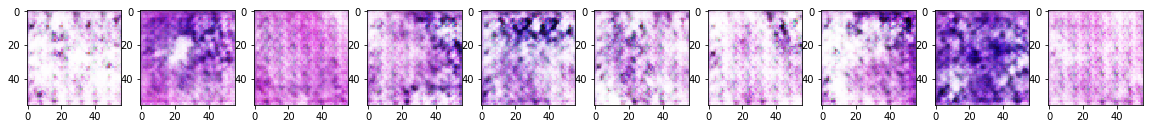

Epochs 0/2: Generator Loss: 0.692. Discriminator Loss: 1.548
Epochs 0/2: Generator Loss: 0.751. Discriminator Loss: 1.307


In [ ]:
epochs = 2
batch_size = 32
z_dim = 100
learning_rate = 2e-4
beta1 = 0.5
alpha = 0.2

image_width = 56
image_height = 56
image_channels = 3

global losses 
global samples

name_run = 'h%s_w%s_n%s' % (image_height, image_width, image_channels)
data_out_path = '/Users/adalbertoclaudioquiros/Documents/Code/UofG/PhD/Cancer_TMA_Generative/data model output/DCGAN/%s' % name_run
data = Data(patch_h=image_height, patch_w=image_width, n_channels=image_channels, batch_size=batch_size)

with tf.Graph().as_default():
   train(epochs, batch_size, z_dim, learning_rate, beta1, data, alpha, image_width, image_height, image_channels, data_out_path)

save_loss(losses, data_out_path, dim=20)